# Importing libraries
# Set the seed for the random number generator


In [1]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint
np.random.seed(107)

import matplotlib.pyplot as plt

# Test for cointegration 
# It returns a cointegration test score matrix, a p-value matrix, and any pairs for which the p-value was less than 0.05

In [2]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

# Installing clairvoyant library in terminal before importing it below

# pip install clairvoyant

# We get the data for stocks from 2011/12/01 till 2020/12/01 from yahoo data source

In [3]:
from clairvoyant.engine import Backtest

from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime
startDateStr = '2011/12/01'
endDateStr = '2020/12/01'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['SPY','AAPL','ADBE','QCOM','EBAY',
                 'HPQ','JNPR','AMD','IBM','ETH', 'COF','NLY','SIM','NYMT','RWT']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']
data.head(5)

Processing data for stock: SPY
Processing data for stock: AAPL
Processing data for stock: ADBE
Processing data for stock: QCOM
Processing data for stock: EBAY
Processing data for stock: HPQ
Processing data for stock: JNPR
Processing data for stock: AMD
Processing data for stock: IBM
Processing data for stock: ETH
Processing data for stock: COF
Processing data for stock: NLY
Processing data for stock: SIM
Processing data for stock: NYMT
Processing data for stock: RWT
20% done...
40% done...
60% done...
80% done...


,SPY,AAPL,ADBE,QCOM,EBAY,HPQ,JNPR,AMD,IBM,ETH,COF,NLY,SIM,NYMT,RWT
2011-12-01,103.565163,11.913649,27.139999,41.947304,12.092983,9.802757,19.071377,5.70,135.646225,14.417994,38.622444,5.335460,6.587518,1.798246,5.211419
2011-12-02,103.473991,11.968005,27.110001,41.648399,12.060388,9.615181,19.371376,5.65,135.796661,14.501860,39.131649,5.358570,6.596849,1.830167,5.211419
2011-12-05,104.601028,12.069658,27.910000,41.763367,12.508577,9.768022,20.022802,5.76,136.641449,15.081931,40.391727,5.371776,6.540864,1.835488,5.323274
2011-12-06,104.634201,12.006392,27.959999,42.023960,12.590067,9.788859,19.474232,5.66,138.145050,15.116879,39.425095,5.378382,6.718149,1.827508,5.353777
2011-12-07,105.023697,11.949272,27.860001,41.732700,12.606366,9.868756,18.265667,5.72,138.939819,15.564159,39.925667,5.398189,6.596849,1.822187,5.440208


# We find the co integrated pair using the about function find_cointegrated_pairs()

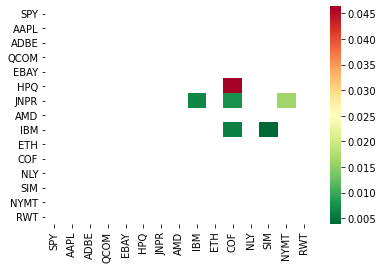

In [4]:
scores, pvalues, pairs = find_cointegrated_pairs(data)
import seaborn
seaborn.heatmap(pvalues, xticklabels=instrumentIds, 
                yticklabels=instrumentIds, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
plt.show()

In [5]:
print(pairs)

[('HPQ', 'COF'), ('JNPR', 'IBM'), ('JNPR', 'COF'), ('JNPR', 'NYMT'), ('IBM', 'COF'), ('IBM', 'SIM')]


# We checked all the pairs for lower p-value and found that IBM and SIM was the best cointegrated pair

In [6]:
S1 = data['IBM']
S2 = data['SIM']
print(S2)
score,pvalue,_= coint(S1,S2)
print(score,pvalue)

2011-12-01    6.587518
2011-12-02    6.596849
2011-12-05    6.540864
2011-12-06    6.718149
2011-12-07    6.596849
                ...   
2020-11-23    9.630000
2020-11-24    9.360000
2020-11-25    9.360000
2020-11-27    9.360000
2020-11-30    9.260000
Name: SIM, Length: 2264, dtype: float64
-4.179503947449904 0.003917430321781199


# We plot the ratio to check if it moved around a stable mean, the plot confirms that

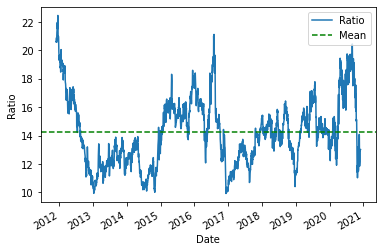

<Figure size 432x288 with 0 Axes>

In [7]:
ratios = S1/S2
ratios.plot()
plt.axhline(ratios.mean(),color = 'green',linestyle = '--')
plt.legend(['Ratio','Mean'])
plt.yticks()
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.show()
plt.savefig('cointegration_test.png')

In [8]:
print(len(ratios))

2264


# Normalizing using z-score method

In [9]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

# We plot the ratio using the normalized data

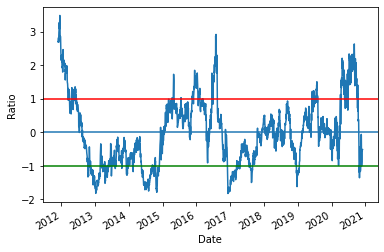

In [10]:
zscore(ratios).plot()
plt.axhline(zscore(ratios).mean())
plt.axhline(1.0,color = 'red')
plt.axhline(-1.0,color = 'green')
#plt.legend(['Ratio','Mean','-1','1'])
plt.yticks()
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.show()

# We put 80% of 2264 rows into training and rest into testing the model

In [11]:
train = ratios[:2014]
test = ratios[2014:]
print (len(train))
print (len(test))

2014
250


# features for model:
## 5 day Moving Average of Ratio: Measure of current value of mean
## 60 day Moving Average of Ratio: Measure of rolling mean
## 60 day Standard Deviation
## z score: (5d MA — 60d MA) /60d SD

In [12]:
mvg_5 = train.rolling(window = 5,center = False).mean()
mvg_60 = train.rolling(window = 60,center = False).mean()
std_60 = train.rolling(window = 5,center = False).std()
z_score_60_5 = (mvg_5 - mvg_60) / std_60
print(z_score_60_5)

2011-12-01         NaN
2011-12-02         NaN
2011-12-05         NaN
2011-12-06         NaN
2011-12-07         NaN
                ...   
2019-11-26   -0.994463
2019-11-27   -0.945524
2019-11-29   -1.159314
2019-12-02   -0.984465
2019-12-03   -1.239930
Length: 2014, dtype: float64


# This plot shows the 60-day and 5-day moving average of price ratios

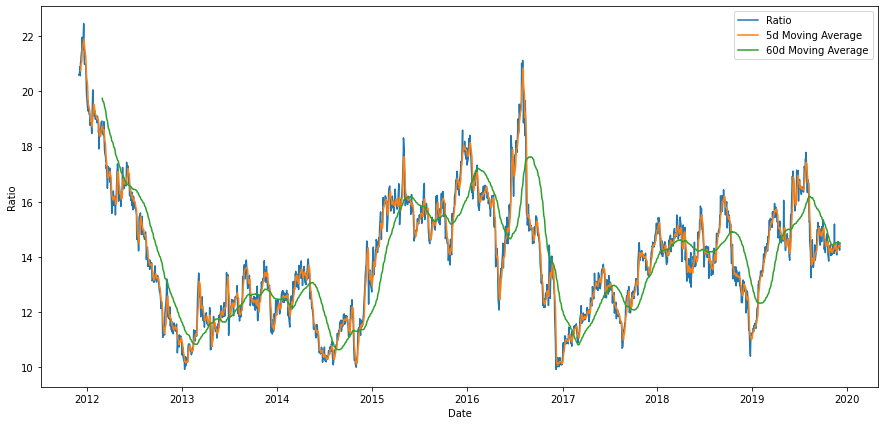

In [13]:
plt.figure(figsize = (15,7))
plt.plot(train.index,train.values)
plt.plot(mvg_5.index,mvg_5.values)
plt.plot(mvg_60.index,mvg_60.values)
plt.legend(['Ratio','5d Moving Average','60d Moving Average'])
plt.ylabel('Ratio')
plt.xlabel('Date')
plt.show()

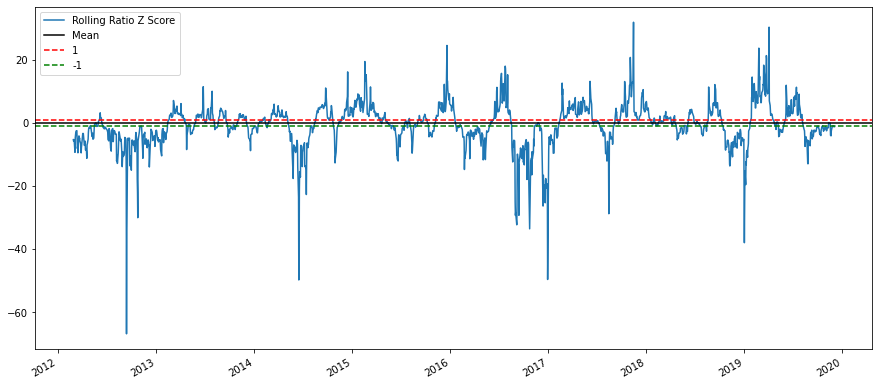

In [14]:
plt.figure(figsize=(15,7))
z_score_60_5.plot()
plt.axhline(0,color = 'black')
plt.axhline(1.0,color = 'red',linestyle = '--')
plt.axhline(-1.0,color = 'green',linestyle = '--')
plt.legend(['Rolling Ratio Z Score','Mean','1','-1'])
#plt.yticks(np.arange(-3,3,step = 1))
plt.show()

# This plot shows the buy and sell signal for the price ratio of IBM and SIM stocks

2011-12-01    20.591401
2011-12-02    20.585079
2011-12-05    20.890428
2011-12-06    20.562963
2011-12-07    21.061543
                ...    
2019-11-26     0.000000
2019-11-27     0.000000
2019-11-29    14.398135
2019-12-02     0.000000
2019-12-03    14.492181
Length: 2014, dtype: float64


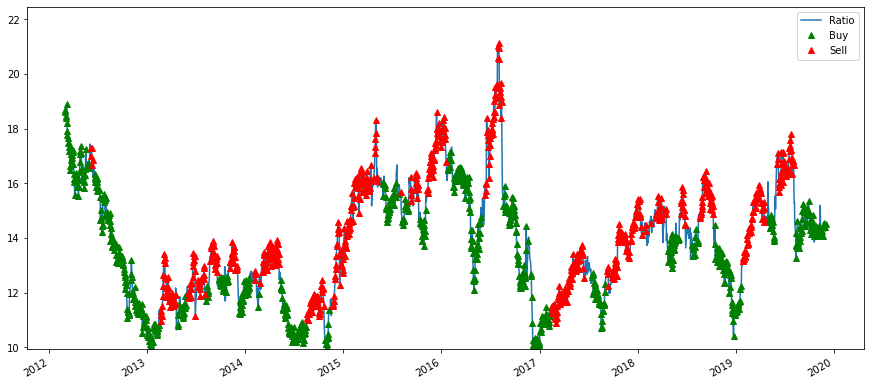

In [15]:
plt.figure(figsize = (15,7))
train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[z_score_60_5 > -1] = 0
sell[z_score_60_5 < 1] = 0
print(buy)
buy[60:].plot(color = 'g',linestyle= 'None',marker = '^')
sell[60:].plot(color = 'r',linestyle= 'None',marker = '^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio','Buy','Sell'])
plt.show()

# This plot shows the buy and sell signal for the IBM and SIM stocks

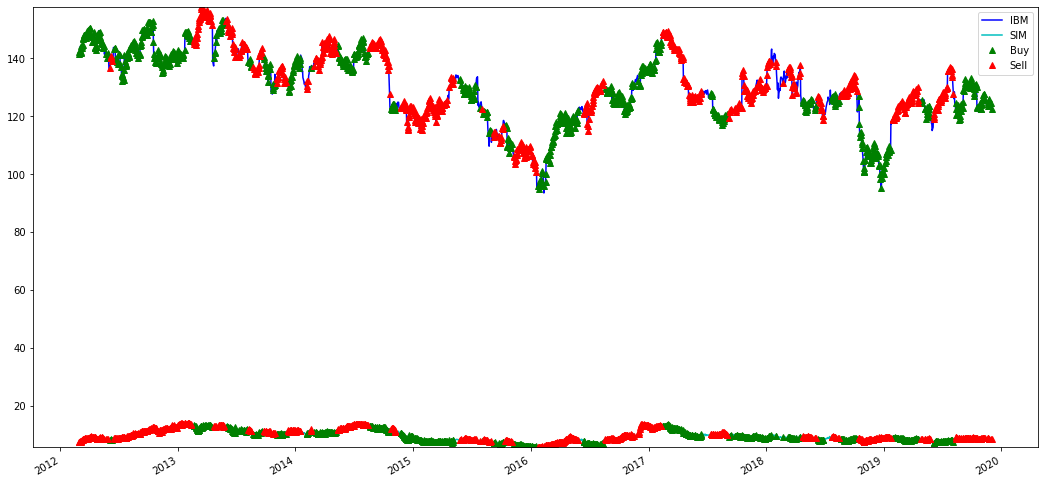

In [16]:
plt.figure(figsize = (18,9))
S1 = data['IBM'].iloc[:2014]
S2 = data['SIM'].iloc[:2014]
S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]
buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))
plt.legend(['IBM','SIM', 'Buy', 'Sell'])
plt.show()

# Training and validating our model

In [17]:
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
            
    return money

# Checking profit / loss for different trading windows

In [18]:
all_trade= []
trade1 = trade(data['IBM'].iloc[:2014], data['SIM'].iloc[:2014], 5, 30)
trade2 = trade(data['IBM'].iloc[:2014], data['SIM'].iloc[:2014], 5, 60)
trade3 = trade(data['IBM'].iloc[:2014], data['SIM'].iloc[:2014], 5, 90)
trade4 = trade(data['IBM'].iloc[:2014], data['SIM'].iloc[:2014], 5, 120)
all_trade.append(trade1)
all_trade.append(trade2)
all_trade.append(trade3)
all_trade.append(trade4)
print(all_trade)

[1070.5919959083883, 1521.381978817906, 2229.855123835668, 1529.0780822900485]


# Calculating sharpe ratio to evaluate model accuracy

In [19]:
import math
sharpe_ratio = math.sqrt(len(all_trade)) * np.mean(all_trade) / np.std(all_trade)
print(sharpe_ratio)

7.658933630297253


# Checking profit / loss for different trading windows

In [20]:
all_trade_2= []
trade1 = trade(data['IBM'].iloc[:2014], data['SIM'].iloc[:2014],10, 60)
trade2 = trade(data['IBM'].iloc[:2014], data['SIM'].iloc[:2014], 10, 90)
trade3 = trade(data['IBM'].iloc[:2014], data['SIM'].iloc[:2014], 10, 120)
trade4 = trade(data['IBM'].iloc[:2014], data['SIM'].iloc[:2014], 10, 150)
all_trade_2.append(trade1)
all_trade_2.append(trade2)
all_trade_2.append(trade3)
all_trade_2.append(trade4)
print(all_trade_2)

[1124.257055352563, 3117.5361251791433, 1374.0535682764785, 3307.482386047255]


# Calculating sharpe ratio to evaluate model accuracy

In [21]:
import math
sharpe_ratio = math.sqrt(len(all_trade_2)) * np.mean(all_trade_2) / np.std(all_trade_2)
print(sharpe_ratio)

4.516189309954305
